In [14]:
%pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

In [15]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA is available!")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("CUDA is not available. Using CPU.")
disable_progress_bar()

Training on cpu
Flower 1.20.0 / PyTorch 2.8.0+cu126
CUDA is not available. Using CPU.


In [16]:
NUM_CLIENTS = 10
BATCH_SIZE = 32


def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader

### Giới thiệu về `flwr-datasets` và `load_datasets`

Cell code phía trên định nghĩa hàm `load_datasets` để chuẩn bị dữ liệu cho mỗi client.

- **`FederatedDataset`**: Đây là một tiện ích từ `flwr-datasets` giúp đơn giản hóa việc tải và phân chia các bộ dữ liệu phổ biến cho môi trường học liên kết.
  - `dataset="cifar10"`: Chỉ định bộ dữ liệu cần tải là CIFAR-10.
  - `partitioners={"train": NUM_CLIENTS}`: Yêu cầu chia tập huấn luyện (`train`) thành `NUM_CLIENTS` (10) phần riêng biệt. Mỗi client sẽ nhận một phần dữ liệu duy nhất, mô phỏng môi trường thực tế nơi mỗi tổ chức có dữ liệu riêng.

- **`load_partition(partition_id)`**: Tải phần dữ liệu cụ thể cho một client dựa trên `partition_id` của nó.

- **`train_test_split(test_size=0.2)`**: Dữ liệu của mỗi client được chia thành 80% cho huấn luyện cục bộ (`trainloader`) và 20% cho đánh giá cục bộ (`valloader`).

- **`transforms` và `DataLoader`**: Dữ liệu ảnh được chuẩn hóa và gói vào `DataLoader` của PyTorch để cung cấp cho mô hình trong quá trình huấn luyện và đánh giá.

/usr/local/lib/python3.12/dist-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


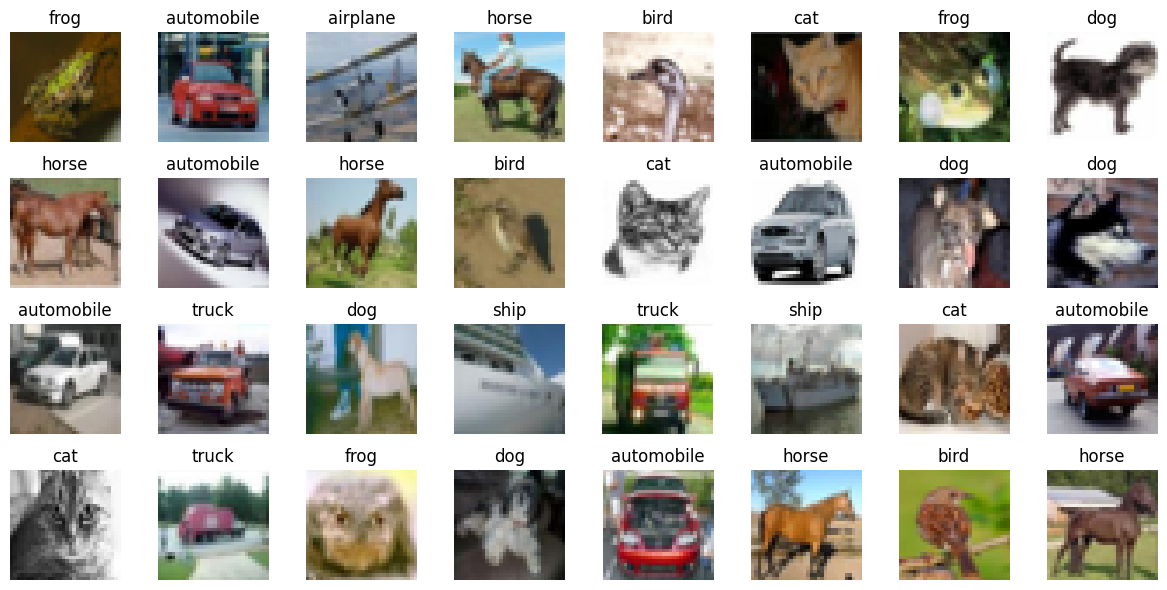

In [17]:
trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()

# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

### Mô hình Neural và Vòng lặp Huấn luyện/Đánh giá Cục bộ

Các cell code tiếp theo định nghĩa kiến trúc mô hình và các hàm cần thiết để thực hiện việc học trên mỗi client.

- **`Net` Class**: Đây là một kiến trúc mạng CNN (Convolutional Neural Network) đơn giản được xây dựng bằng PyTorch, phù hợp cho bộ dữ liệu CIFAR-10. Nó bao gồm các lớp tích chập để trích xuất đặc trưng và các lớp kết nối đầy đủ để phân loại ảnh.

- **`train(net, trainloader, epochs)` function**: Hàm này thực hiện quá trình huấn luyện mô hình (`net`) trên dữ liệu cục bộ của client (`trainloader`).
  - Nó lặp qua dữ liệu trong một số `epochs` nhất định.
  - Trong mỗi vòng lặp, nó tính toán `loss`, thực hiện lan truyền ngược (`backward pass`) và cập nhật trọng số của mô hình (`optimizer.step()`).
  - Đây là bước cốt lõi nơi client học từ dữ liệu của riêng mình.

- **`test(net, testloader)` function**: Hàm này đánh giá hiệu suất của mô hình trên một tập dữ liệu.
  - Trong kịch bản học liên kết, nó thường được dùng để đánh giá mô hình trên tập kiểm định cục bộ (`valloader`) của client.
  - Nó trả về `loss` và `accuracy` trung bình.

In [18]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Giới thiệu Flower Client và các hàm tiện ích

Để một client có thể giao tiếp với server trong Flower, chúng ta cần định nghĩa logic của nó.

- **`get_parameters(net)`**: Hàm này trích xuất các trọng số (tham số) từ mô hình PyTorch và chuyển chúng thành một danh sách các mảng NumPy. Client sẽ gọi hàm này để gửi các cập nhật của nó lên server.

- **`set_parameters(net, parameters)`**: Hàm này nhận một danh sách tham số (thường là từ server) và cập nhật vào mô hình cục bộ.

- **`FlowerClient(NumPyClient)`**: Đây là lớp chính định nghĩa hành vi của client.
  - **`fit(self, parameters, config)`**: Đây là hàm quan trọng nhất. Server gọi hàm này để yêu cầu client huấn luyện.
    1. Client nhận tham số mô hình toàn cục (`parameters`) từ server.
    2. Nó cập nhật mô hình cục bộ của mình bằng `set_parameters`.
    3. Nó gọi hàm `train()` để huấn luyện mô hình trên dữ liệu cục bộ.
    4. Cuối cùng, nó trả về các tham số đã được cập nhật, số lượng mẫu huấn luyện, và một dictionary (có thể chứa metrics).
  - **`evaluate(self, parameters, config)`**: Server gọi hàm này để yêu cầu client đánh giá mô hình.
    1. Client nhận tham số mô hình.
    2. Nó đánh giá mô hình trên tập `valloader` cục bộ.
    3. Nó trả về `loss`, số lượng mẫu đánh giá, và một dictionary chứa các chỉ số (ví dụ: `{"accuracy": ...}`).

In [19]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

### `client_fn` và `ClientApp`: Tạo Client trong môi trường mô phỏng

Flower cung cấp một cách linh hoạt để tạo các client trong môi trường mô phỏng thông qua `client_fn` và `ClientApp`.

- **`client_fn(context: Context)`**: Đây là một "hàm nhà máy" (factory function). Flower sẽ gọi hàm này mỗi khi cần tạo một thực thể client mới cho một node trong mô phỏng.
  - **`context.node_config["partition-id"]`**: `context` chứa thông tin về node đang được tạo. Ở đây, chúng ta sử dụng `partition-id` để đảm bảo mỗi client tải một phần dữ liệu riêng biệt thông qua hàm `load_datasets`.
  - Việc tạo một mô hình `Net()` mới và tải dữ liệu riêng cho mỗi client đảm bảo rằng trạng thái của các client được cách ly hoàn toàn, giống như trong một hệ thống thực.

- **`ClientApp(client_fn=client_fn)`**: `ClientApp` là một đối tượng đóng gói `client_fn`. Nó được cung cấp cho `run_simulation` để Flower biết cách tạo các client khi cần thiết.

In [20]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [21]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [22]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [23]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

### Cấu hình Chiến lược (`Strategy`) và Server

Server trong Flower điều phối toàn bộ quá trình học liên kết thông qua một `Strategy`.

- **`FedAvg`**: Đây là chiến lược tổng hợp mô hình phổ biến nhất. Về cơ bản, sau mỗi vòng, server sẽ tính trung bình có trọng số của các tham số nhận được từ các client để tạo ra mô hình toàn cục mới.
  - `fraction_fit`: Tỷ lệ client được chọn để huấn luyện trong mỗi vòng (1.0 = 100%).
  - `fraction_evaluate`: Tỷ lệ client được chọn để đánh giá.
  - `min_fit_clients`, `min_evaluate_clients`, `min_available_clients`: Các ngưỡng tối thiểu để đảm bảo tính ổn định của quá trình học, ngay cả khi một số client không khả dụng.
  - `evaluate_metrics_aggregation_fn`: Cho phép bạn cung cấp một hàm tùy chỉnh (`weighted_average`) để tổng hợp các chỉ số (metrics) từ các client. Ở đây, chúng ta tính trung bình `accuracy` có trọng số.

- **`ServerConfig`**: Dùng để cấu hình các tham số cho server, quan trọng nhất là `num_rounds` (số vòng học liên kết sẽ chạy).

- **`ServerApp`**: Tương tự như `ClientApp`, `ServerApp` đóng gói logic của server (bao gồm chiến lược và cấu hình) để chuẩn bị cho việc chạy mô phỏng.

In [24]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [25]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

### Chạy Mô phỏng với `run_simulation`

Cell cuối cùng khởi động toàn bộ quá trình học liên kết mô phỏng.

- **`backend_config`**: Cấu hình này chỉ định tài nguyên phần cứng (CPU, GPU) mà mỗi client sẽ được cấp phát trong quá trình mô phỏng. Điều này rất hữu ích khi bạn muốn mô phỏng các kịch bản với tài nguyên hạn chế hoặc khi chạy trên các máy có GPU.

- **`server_fn(context: Context)`**: Tương tự như `client_fn`, hàm này cho phép cấu hình server một cách linh hoạt ngay trước khi quá trình mô phỏng bắt đầu. Nó tạo ra chiến lược và cấu hình server, sau đó trả về dưới dạng `ServerAppComponents`.

- **`run_simulation(...)`**: Đây là hàm chính để bắt đầu mô phỏng.
  - `server_app`: Cung cấp logic của server.
  - `client_app`: Cung cấp logic để tạo client.
  - `num_supernodes`: Số lượng client sẽ tham gia vào mô phỏng.
  - `backend_config`: Cấu hình tài nguyên cho các client.

Khi hàm này được gọi, Flower sẽ điều phối các vòng lặp: server chọn client, gửi mô hình, client huấn luyện, gửi lại cập nhật, và server tổng hợp kết quả. Quá trình này lặp lại cho đến khi đủ `num_rounds`.

In [26]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    )

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)

    return ServerAppComponents(strategy=strategy, config=config)


# Create a new server instance with the updated FedAvg strategy
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=5443) 2025-08-30 14:13:31.250901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=5443) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=5443) E0000 00:00:1756563211.567975    5443 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

## Tham khảo

- Flower Docs: https://flower.ai/docs/
- Examples: https://github.com/adap/flower/tree/main/examples
- Flower Datasets: https://flower.ai/docs/datasets/
- Hugging Face Datasets: https://huggingface.co/docs/datasets